In [296]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from sklearn.cluster import AgglomerativeClustering
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [297]:
#Loading the dataset
data = pd.read_csv("Dataset/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Cleaning

In [298]:
#Information on features 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [299]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [300]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  

# Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))


The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [301]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [302]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Customer_For
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,0,3,11,1,57283200000000000
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,3,11,0,9763200000000000
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,3,11,0,26956800000000000
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,0,3,11,0,12009600000000000
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,0,3,11,0,13910400000000000


In [303]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [304]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2024-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})
# Children
#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})
#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [305]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,131.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

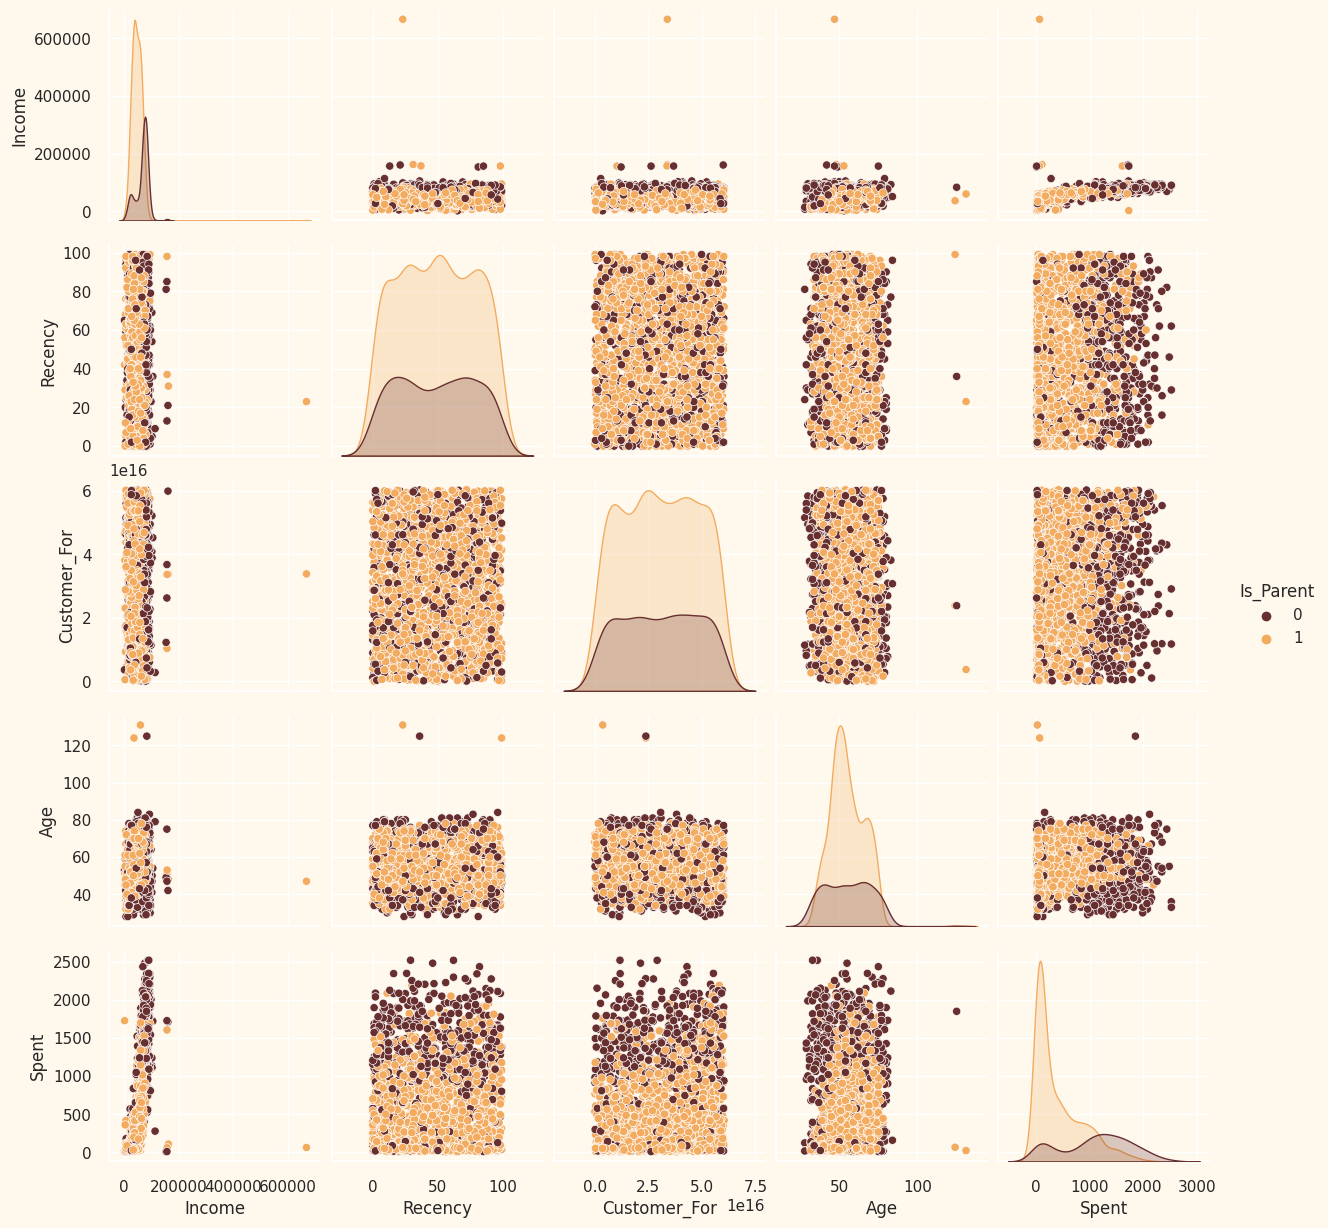

In [306]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

Clearly, there are a few outliers in the Income and Age features. I will be deleting the outliers in the data.



In [307]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


## Data preprocessing

In [308]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [309]:
object_cols

['Education', 'Living_With']

In [310]:
#Label Encoding the object dtypes.

for i in object_cols:
    le=LabelEncoder()
    le.fit(data[i])

    data[i] = le.transform(data[i])

    filehandler = open(f"Pipeline/{i}-label.obj","wb")
    pickle.dump(le,filehandler)

print("All features are now numerical")

All features are now numerical


In [311]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response','Customer_For','Is_Parent']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )

filehandler = open(f"Pipeline/scaler.obj","wb")
pickle.dump(scaler,filehandler)

print("All features are now scaled")

All features are now scaled


In [312]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,0.351030,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,-1.349603,-1.264598,-1.758359
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,-1.349603,1.404572,0.449070
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.688432,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,0.740959,-1.264598,-0.654644
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,-0.920135,0.740959,0.069987,0.449070
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,1.390492,0.332600,0.111982,0.059532,-0.132545,-1.033114,-0.307562,0.740959,0.069987,0.449070


In [313]:
# Wines

## Dimensionality reduction

In [314]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
filehandler = open(f"Pipeline/pca.obj","wb")
pickle.dump(pca,filehandler)
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-9.636656e-17,2.798335,-5.864095,-2.490959,-0.747811,2.417165,7.252789
col2,2212.0,-5.781993e-17,1.625052,-3.848806,-1.310990,-0.139562,1.165158,6.298457
col3,2212.0,3.131913e-17,1.153481,-2.982532,-0.892554,-0.116546,0.791330,3.936535


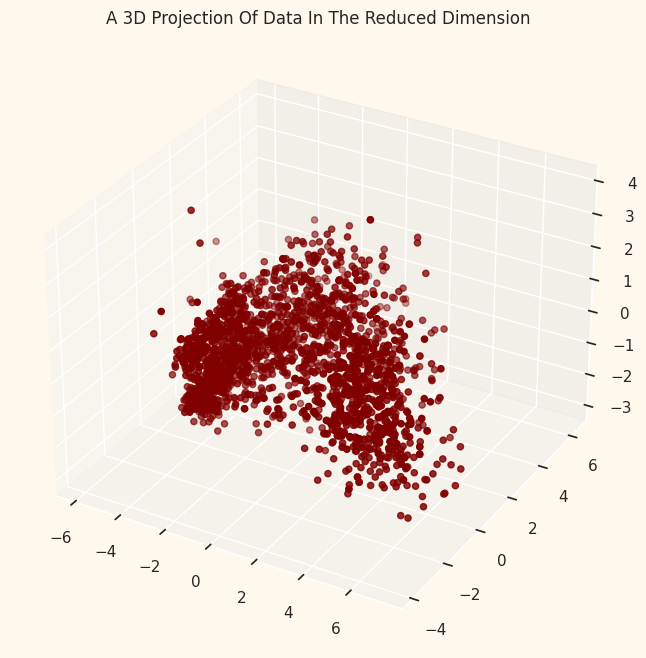

In [315]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## CLUSTERING

Elbow Method to determine the number of clusters to be formed:


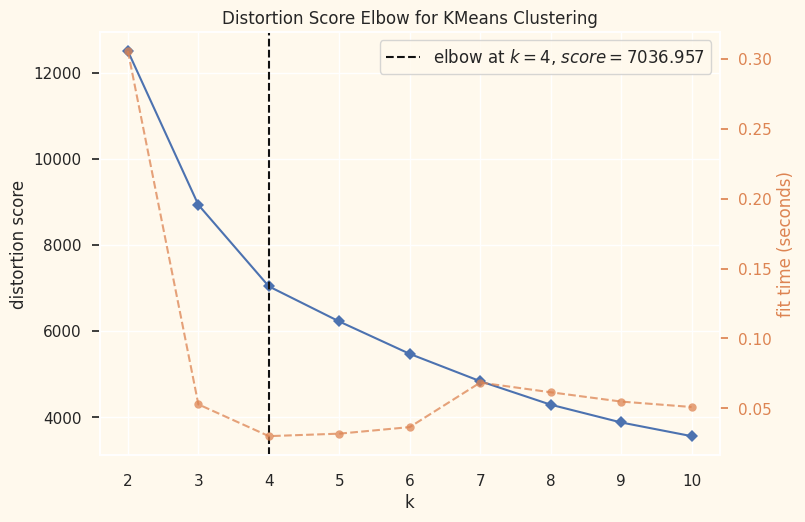

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [316]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

The above cell indicates that four will be an optimal number of clusters for this data. 
Next, we will be fitting the Agglomerative Clustering Model to get the final clusters. 

In [317]:
#Initiating the Agglomerative Clustering model 
AC = KMeans(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)

filehandler = open(f"Model/agglome.obj","wb")
pickle.dump(AC,filehandler)

PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

To examine the clusters formed let's have a look at the 3-D distribution of the clusters. 

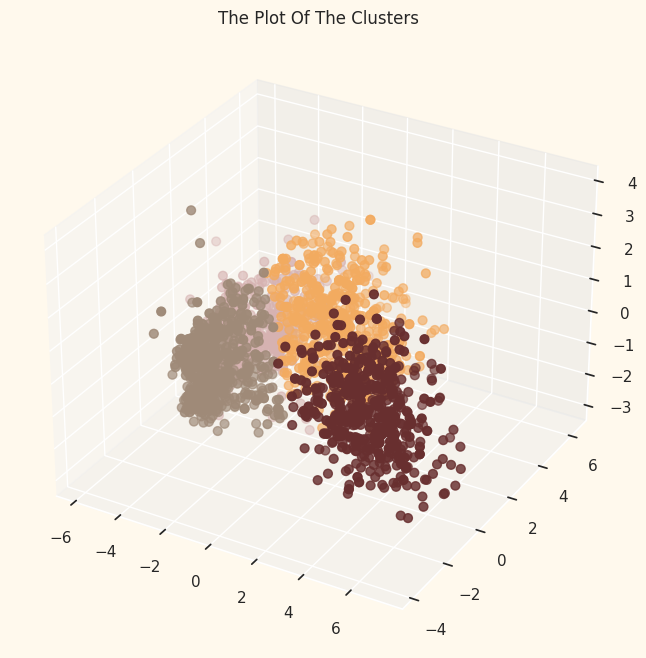

In [318]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

## EVALUATING MODELS

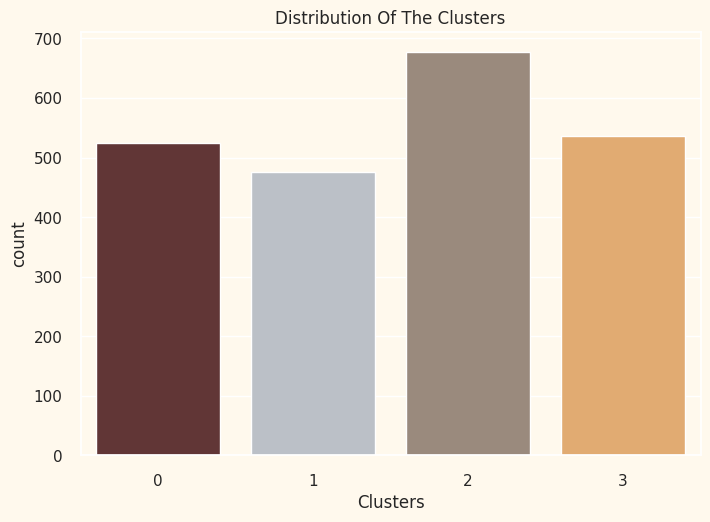

In [319]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

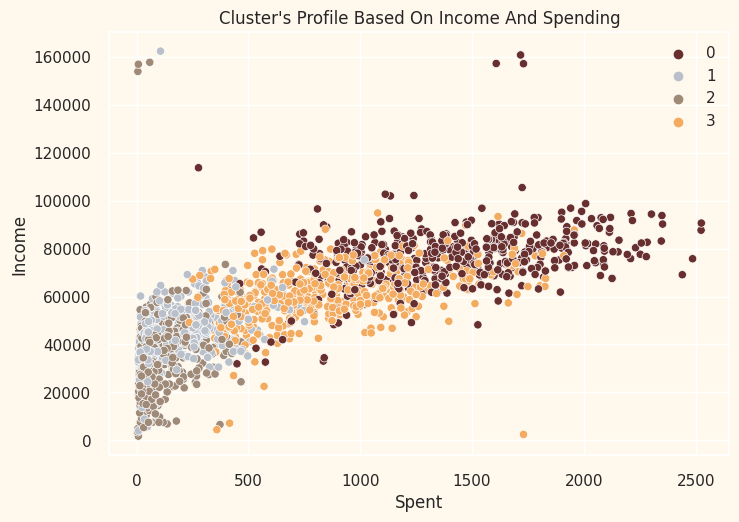

In [320]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Income vs  spending plot shows the clusters pattern**
* group 0: high spending & average income
* group 1: high spending & high income
* group 2: low spending & low income 
* group 3: high spending & low income  

Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

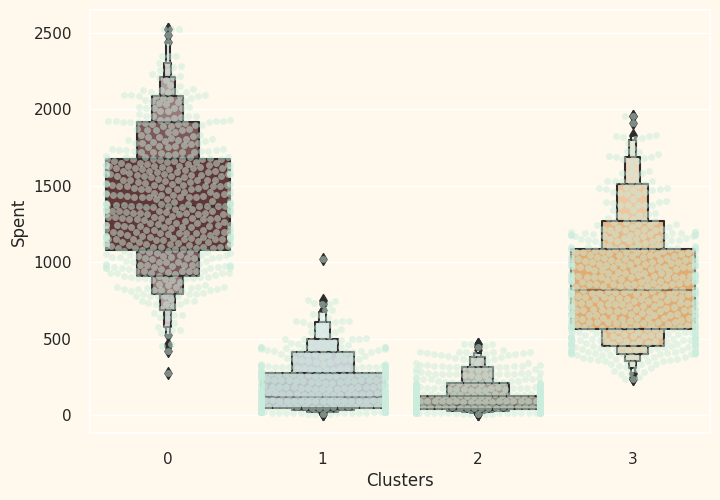

In [321]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()


From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers closely followed by cluster 0.
We can explore what each cluster is spending on for the targeted marketing strategies.


Let us next explore how did our campaigns do in the past.

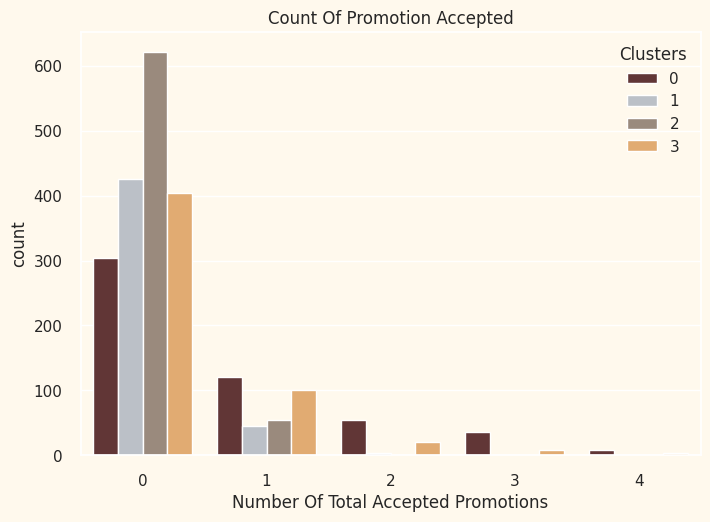

In [322]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales. 


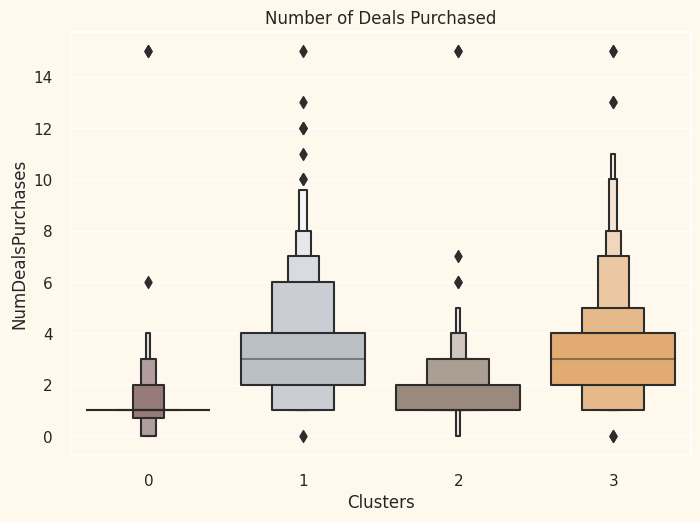

In [323]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. 
However, our star customers cluster 1 are not much into the deals. 
Nothing seems to attract cluster 2 overwhelmingly 


<Figure size 800x550 with 0 Axes>

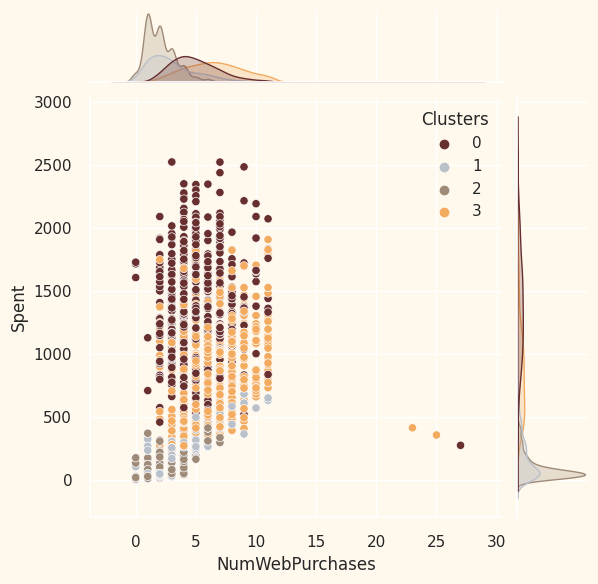

<Figure size 800x550 with 0 Axes>

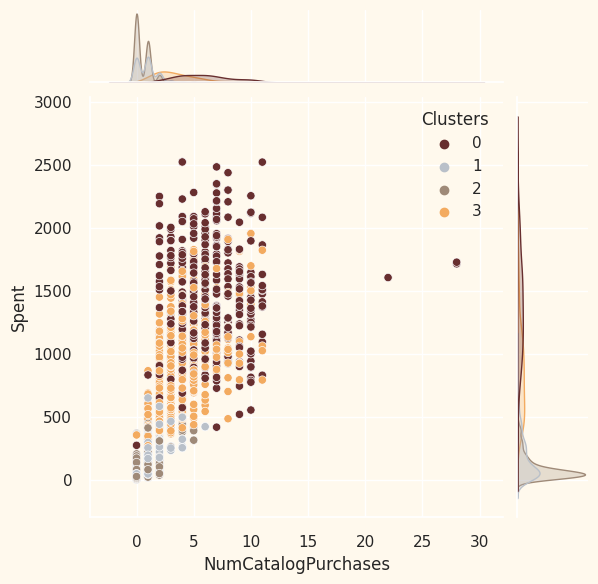

<Figure size 800x550 with 0 Axes>

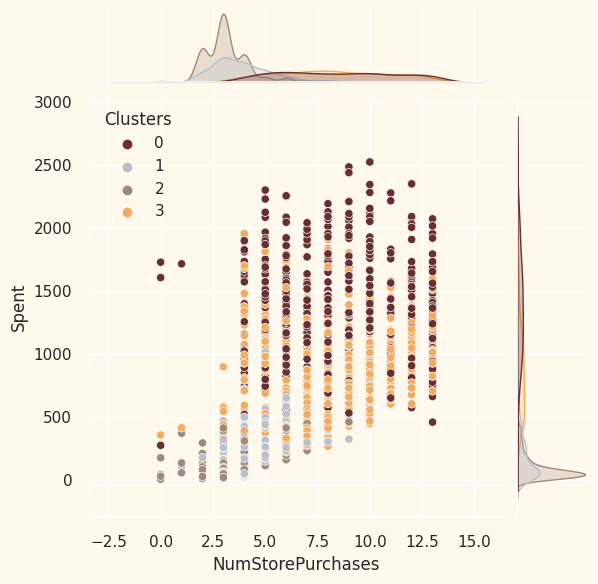

<Figure size 800x550 with 0 Axes>

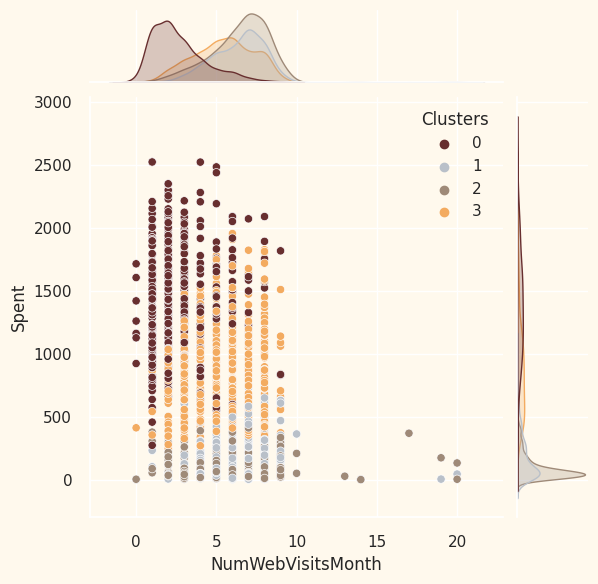

In [324]:
#for more details on the purchasing style 
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumWebVisitsMonth"] 

for i in Places:
    plt.figure()
    sns.jointplot(x=data[i],y = data["Spent"],hue=data["Clusters"], palette= pal)
    plt.show()

## PROFILING

<Figure size 800x550 with 0 Axes>

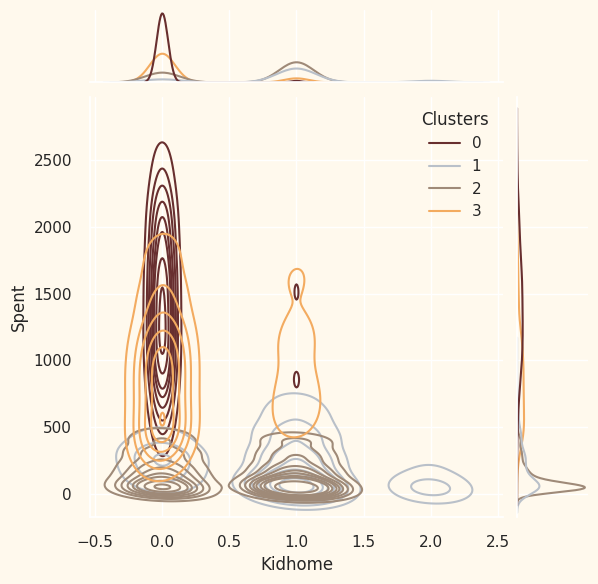

<Figure size 800x550 with 0 Axes>

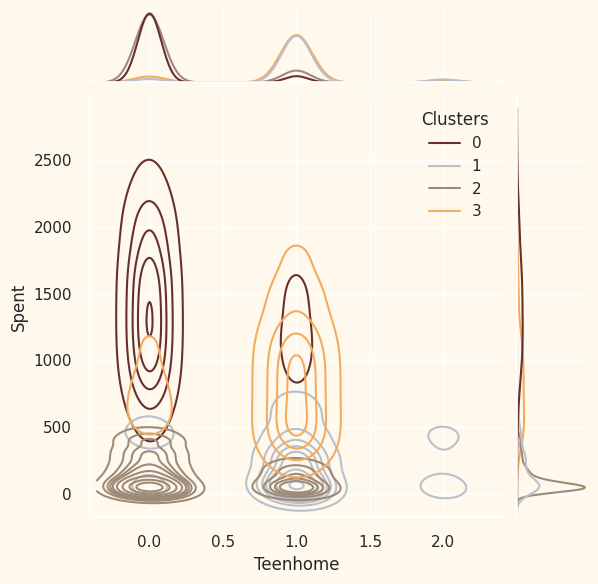

<Figure size 800x550 with 0 Axes>

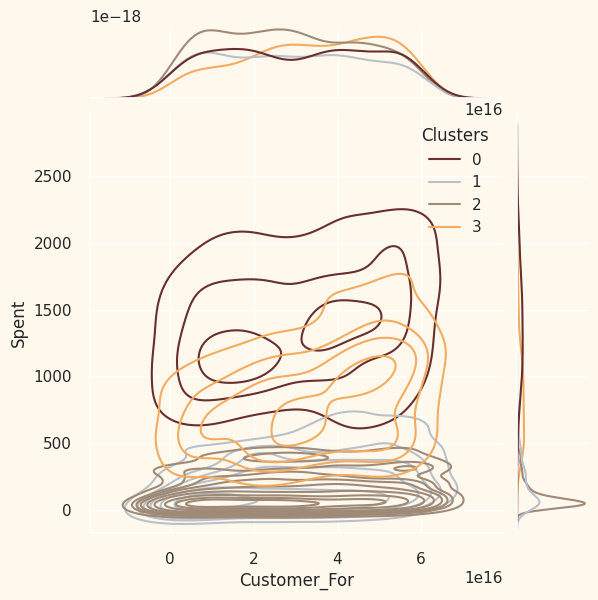

<Figure size 800x550 with 0 Axes>

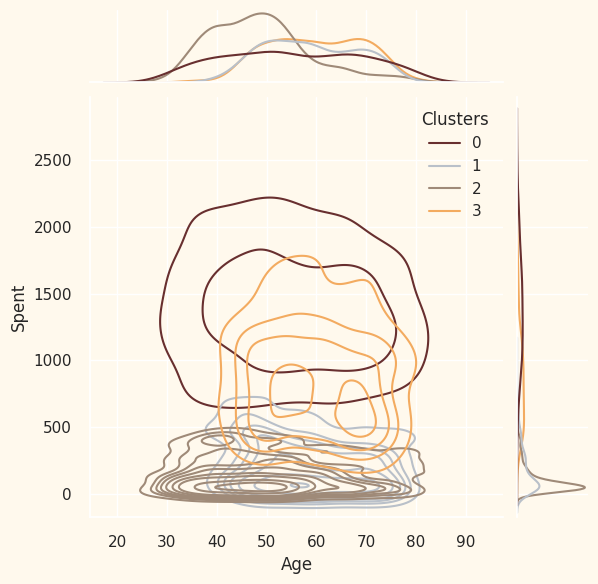

<Figure size 800x550 with 0 Axes>

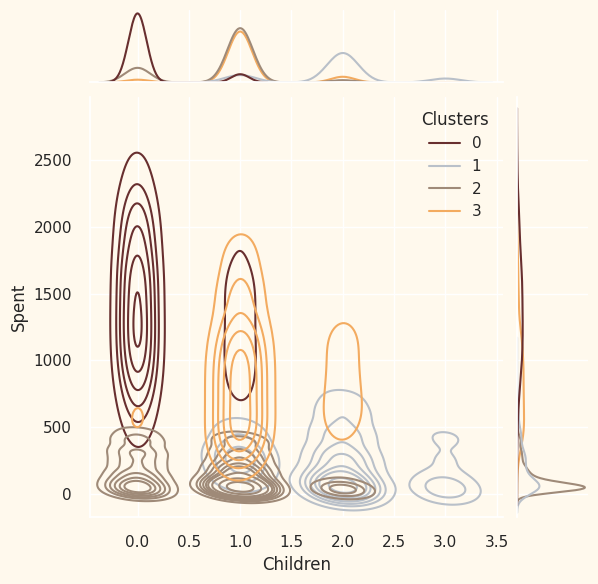

<Figure size 800x550 with 0 Axes>

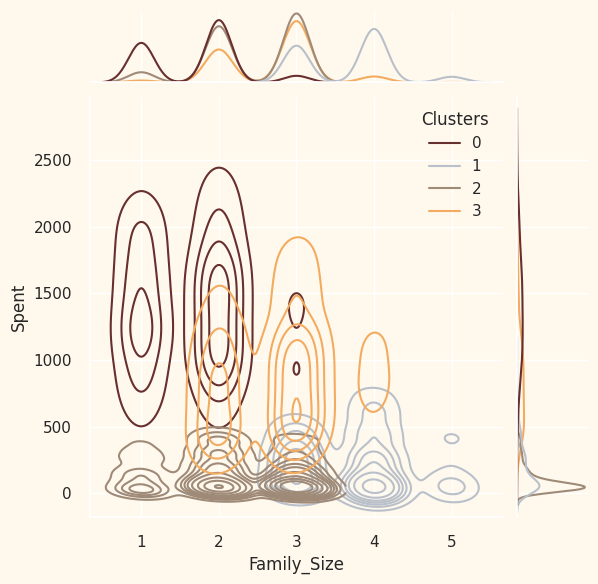

<Figure size 800x550 with 0 Axes>

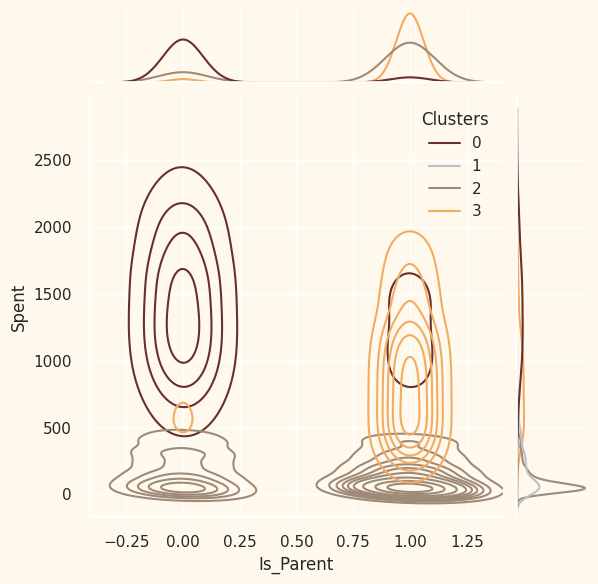

<Figure size 800x550 with 0 Axes>

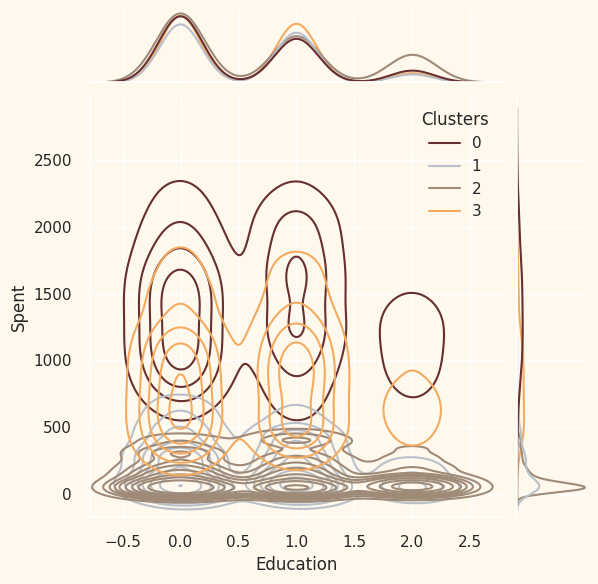

<Figure size 800x550 with 0 Axes>

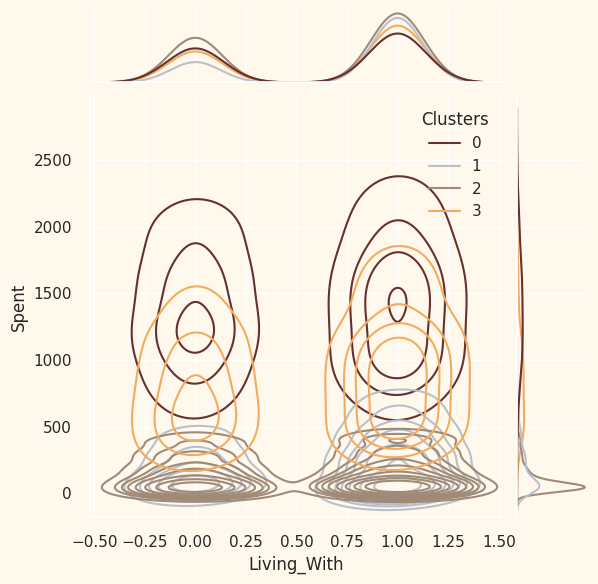

In [325]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()
